In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
matches = pd.read_csv("matches.csv", index_col=0)
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team
1,2023-08-19,15:30,Bundesliga,Matchweek 1,Sat,Home,W,3.0,2.0,RB Leipzig,...,11.0,14.0,8.0,15.0,574.0,22.0,11.0,50.0,2023-2024,Bayer Leverkusen
2,2023-08-26,18:30,Bundesliga,Matchweek 2,Sat,Away,W,3.0,0.0,M'Gladbach,...,11.0,9.0,9.0,11.0,854.0,16.0,7.0,43.8,2023-2024,Bayer Leverkusen
3,2023-09-02,15:30,Bundesliga,Matchweek 3,Sat,Home,W,5.0,1.0,Darmstadt 98,...,4.0,10.0,4.0,3.0,913.0,26.0,15.0,57.7,2023-2024,Bayer Leverkusen
4,2023-09-15,20:30,Bundesliga,Matchweek 4,Fri,Away,D,2.0,2.0,Bayern Munich,...,12.0,9.0,21.0,19.0,744.0,33.0,16.0,48.5,2023-2024,Bayer Leverkusen
6,2023-09-24,15:30,Bundesliga,Matchweek 5,Sun,Home,W,4.0,1.0,Heidenheim,...,10.0,11.0,4.0,12.0,964.0,23.0,14.0,60.9,2023-2024,Bayer Leverkusen


In [3]:
matches.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

# Data preprocessing

## Get to know data

In [4]:
# drop unnecessary columns
matches_dropped = matches.drop(columns=['time', 'day', 'attendance', 'captain', 'formation', 'referee',
                                        'match report', 'notes'])
matches_dropped.head()

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team
1,2023-08-19,Bundesliga,Matchweek 1,Home,W,3.0,2.0,RB Leipzig,1.4,1.6,...,11.0,14.0,8.0,15.0,574.0,22.0,11.0,50.0,2023-2024,Bayer Leverkusen
2,2023-08-26,Bundesliga,Matchweek 2,Away,W,3.0,0.0,M'Gladbach,2.7,0.9,...,11.0,9.0,9.0,11.0,854.0,16.0,7.0,43.8,2023-2024,Bayer Leverkusen
3,2023-09-02,Bundesliga,Matchweek 3,Home,W,5.0,1.0,Darmstadt 98,2.8,0.4,...,4.0,10.0,4.0,3.0,913.0,26.0,15.0,57.7,2023-2024,Bayer Leverkusen
4,2023-09-15,Bundesliga,Matchweek 4,Away,D,2.0,2.0,Bayern Munich,2.1,2.1,...,12.0,9.0,21.0,19.0,744.0,33.0,16.0,48.5,2023-2024,Bayer Leverkusen
6,2023-09-24,Bundesliga,Matchweek 5,Home,W,4.0,1.0,Heidenheim,3.4,0.5,...,10.0,11.0,4.0,12.0,964.0,23.0,14.0,60.9,2023-2024,Bayer Leverkusen


In [5]:
matches_dropped.columns

Index(['date', 'comp', 'round', 'venue', 'result', 'gf', 'ga', 'opponent',
       'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%', 'stp',
       'stp%', '#opa', 'cmp', 'att_x', 'cmp%', 'totdist', 'prgdist', 'ast',
       'kp', 'ppa', 'crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr', 'touches',
       'att_y', 'succ', 'succ%', 'season', 'team'],
      dtype='object')

**Description:**

Match stats:
- gf = goals for
- ga = goals against
- xg = expected goals
- xga = expected goals allowed
- poss = possession, calculated as the percentage of passess attempted

Shooting:
- sh = shots total
- sot = shots on target
- sot% = shots on target %

Goalkeeping:
- saves = number of saves
- save% = save percentage
- stp = number of crosses into penalty area which was succesfully stopped by the goalkeeper
- stp% = crosses stopped %
- #opa = number of defensive action outside of penalty area

Passing:
- cmp = passes completed
- att_x = passes attempted
- cmp% = pass completion %
- totdist = total distance in yards, that completed passes have traveled in any direction
- prgdist = total distance in yards, that completed passes have traveled towards opponents's goal
- ast = assists
- kp = key passes, directly lead to a shot
- ppa = passes into penalty area
- crspa = crosses into penalty area

Defence:
- tkl = tackles
- tklw = tackles won
- blocks = number of times blocking the ball by standing in its path
- int = interceptions
- clr = clearances

Possession:
- touches = number of times a player touches the ball
- att_y = take-ons attempted
- succ = succesful take-ons
- succ% = succesful take-ons %

In [6]:
# shape
matches_dropped.shape

(2826, 39)

In [7]:
# take a look at first info 
matches_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2826 entries, 1 to 35
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2826 non-null   object 
 1   comp      2826 non-null   object 
 2   round     2826 non-null   object 
 3   venue     2826 non-null   object 
 4   result    2826 non-null   object 
 5   gf        2826 non-null   float64
 6   ga        2826 non-null   float64
 7   opponent  2826 non-null   object 
 8   xg        2824 non-null   float64
 9   xga       2824 non-null   float64
 10  poss      2826 non-null   float64
 11  sh        2826 non-null   float64
 12  sot       2826 non-null   float64
 13  sot%      2825 non-null   float64
 14  saves     2826 non-null   float64
 15  save%     2757 non-null   float64
 16  stp       2824 non-null   float64
 17  stp%      2824 non-null   float64
 18  #opa      2824 non-null   float64
 19  cmp       2824 non-null   float64
 20  att_x     2824 non-null   float64
 21

In [8]:
# take a look at the columns
matches_dropped.columns

Index(['date', 'comp', 'round', 'venue', 'result', 'gf', 'ga', 'opponent',
       'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%', 'stp',
       'stp%', '#opa', 'cmp', 'att_x', 'cmp%', 'totdist', 'prgdist', 'ast',
       'kp', 'ppa', 'crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr', 'touches',
       'att_y', 'succ', 'succ%', 'season', 'team'],
      dtype='object')

In [9]:
# check dtypes
matches_dropped.dtypes

date         object
comp         object
round        object
venue        object
result       object
gf          float64
ga          float64
opponent     object
xg          float64
xga         float64
poss        float64
sh          float64
sot         float64
sot%        float64
saves       float64
save%       float64
stp         float64
stp%        float64
#opa        float64
cmp         float64
att_x       float64
cmp%        float64
totdist     float64
prgdist     float64
ast           int64
kp          float64
ppa         float64
crspa       float64
tkl         float64
tklw        float64
blocks      float64
int         float64
clr         float64
touches     float64
att_y       float64
succ        float64
succ%       float64
season       object
team         object
dtype: object

## Data cleaning

### Duplicates

In [10]:
matches_dropped.head()

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team
1,2023-08-19,Bundesliga,Matchweek 1,Home,W,3.0,2.0,RB Leipzig,1.4,1.6,...,11.0,14.0,8.0,15.0,574.0,22.0,11.0,50.0,2023-2024,Bayer Leverkusen
2,2023-08-26,Bundesliga,Matchweek 2,Away,W,3.0,0.0,M'Gladbach,2.7,0.9,...,11.0,9.0,9.0,11.0,854.0,16.0,7.0,43.8,2023-2024,Bayer Leverkusen
3,2023-09-02,Bundesliga,Matchweek 3,Home,W,5.0,1.0,Darmstadt 98,2.8,0.4,...,4.0,10.0,4.0,3.0,913.0,26.0,15.0,57.7,2023-2024,Bayer Leverkusen
4,2023-09-15,Bundesliga,Matchweek 4,Away,D,2.0,2.0,Bayern Munich,2.1,2.1,...,12.0,9.0,21.0,19.0,744.0,33.0,16.0,48.5,2023-2024,Bayer Leverkusen
6,2023-09-24,Bundesliga,Matchweek 5,Home,W,4.0,1.0,Heidenheim,3.4,0.5,...,10.0,11.0,4.0,12.0,964.0,23.0,14.0,60.9,2023-2024,Bayer Leverkusen


In [11]:
# numeric and non-numeric columns separate
numeric_col = matches_dropped.select_dtypes(include='number').columns
non_numeric_col = matches_dropped.select_dtypes(exclude='number').columns
display(numeric_col)
display(non_numeric_col)

Index(['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%',
       'stp', 'stp%', '#opa', 'cmp', 'att_x', 'cmp%', 'totdist', 'prgdist',
       'ast', 'kp', 'ppa', 'crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr',
       'touches', 'att_y', 'succ', 'succ%'],
      dtype='object')

Index(['date', 'comp', 'round', 'venue', 'result', 'opponent', 'season',
       'team'],
      dtype='object')

In [12]:
# list all duplicated rows
matches_dropped.loc[matches_dropped.duplicated(keep='first'),:]

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team


### non-numeric columns

In [13]:
non_numeric_col

Index(['date', 'comp', 'round', 'venue', 'result', 'opponent', 'season',
       'team'],
      dtype='object')

In [14]:
# turn date column to datetime
matches['date'] = pd.to_datetime(matches['date'])

In [15]:
matches_dropped['comp'].nunique()

1

In [16]:
matches_dropped['venue'].value_counts()

venue
Home    1413
Away    1413
Name: count, dtype: int64

In [17]:
matches_dropped['result'].value_counts()

result
W    1065
L    1065
D     696
Name: count, dtype: int64

In [18]:
matches_dropped['season'].value_counts()

season
2022-2023    612
2021-2022    612
2020-2021    612
2019-2020    612
2023-2024    378
Name: count, dtype: int64

team and opponent names

In [19]:
matches_dropped['team'].unique()

array(['Bayer Leverkusen', 'Bayern Munich', 'Stuttgart', 'Dortmund',
       'RB Leipzig', 'Eintracht Frankfurt', 'Freiburg', 'Hoffenheim',
       'Heidenheim', 'Werder Bremen', 'Augsburg', 'Wolfsburg',
       'Monchengladbach', 'Bochum', 'Union Berlin', 'Koln', 'Mainz 05',
       'Darmstadt 98', 'Schalke 04', 'Hertha BSC', 'Arminia',
       'Greuther Furth', 'Dusseldorf', 'Paderborn 07'], dtype=object)

In [20]:
matches_dropped['opponent'].unique()

array(['RB Leipzig', "M'Gladbach", 'Darmstadt 98', 'Bayern Munich',
       'Heidenheim', 'Mainz 05', 'Köln', 'Wolfsburg', 'Freiburg',
       'Hoffenheim', 'Union Berlin', 'Werder Bremen', 'Dortmund',
       'Stuttgart', 'Eint Frankfurt', 'Bochum', 'Augsburg', 'Leverkusen',
       'Hertha BSC', 'Schalke 04', 'Greuther Fürth', 'Arminia',
       'Paderborn 07', 'Düsseldorf'], dtype=object)

Leverkusen - Bayer Leverkusen
Eintracht Frankfurt - Eint Frankfurt
Monchengladbach - M'Gladbach
Koln - Köln
Greuther Furth - Greuther Fürth
Dusseldorf - Düsseldorf

In [21]:
# rename
matches_dropped.loc[matches_dropped.loc[:,'team']=='Monchengladbach', 'team'] = 'Mönchengladbach'
matches_dropped.loc[matches_dropped.loc[:,'team']=='Koln', 'team'] = 'Köln'
matches_dropped.loc[matches_dropped.loc[:,'team']=='Greuther Furth', 'team'] = 'Greuther Fürth'
matches_dropped.loc[matches_dropped.loc[:,'team']=='Dusseldorf', 'team'] = 'Düsseldorf'

matches_dropped.loc[matches_dropped.loc[:,'opponent']=='Leverkusen', 'opponent'] = 'Bayer Leverkusen'
matches_dropped.loc[matches_dropped.loc[:,'opponent']=='Eint Frankfurt', 'opponent'] = 'Eintracht Frankfurt'
matches_dropped.loc[matches_dropped.loc[:,'opponent']=="M'Gladbach", 'opponent'] = 'Mönchengladbach'
matches_dropped.loc[matches_dropped.loc[:,'opponent']=='Eint Frankfurt', 'opponent'] = 'Eintracht Frankfurt'

In [22]:
matches_dropped['team'].unique()

array(['Bayer Leverkusen', 'Bayern Munich', 'Stuttgart', 'Dortmund',
       'RB Leipzig', 'Eintracht Frankfurt', 'Freiburg', 'Hoffenheim',
       'Heidenheim', 'Werder Bremen', 'Augsburg', 'Wolfsburg',
       'Mönchengladbach', 'Bochum', 'Union Berlin', 'Köln', 'Mainz 05',
       'Darmstadt 98', 'Schalke 04', 'Hertha BSC', 'Arminia',
       'Greuther Fürth', 'Düsseldorf', 'Paderborn 07'], dtype=object)

In [23]:
matches_dropped['opponent'].unique()

array(['RB Leipzig', 'Mönchengladbach', 'Darmstadt 98', 'Bayern Munich',
       'Heidenheim', 'Mainz 05', 'Köln', 'Wolfsburg', 'Freiburg',
       'Hoffenheim', 'Union Berlin', 'Werder Bremen', 'Dortmund',
       'Stuttgart', 'Eintracht Frankfurt', 'Bochum', 'Augsburg',
       'Bayer Leverkusen', 'Hertha BSC', 'Schalke 04', 'Greuther Fürth',
       'Arminia', 'Paderborn 07', 'Düsseldorf'], dtype=object)

In [24]:
# check
np.array_equal(np.sort(matches_dropped['team'].unique()), np.sort(matches_dropped['opponent'].unique()))

True

### Missing values

In [25]:
matches_dropped.shape

(2826, 39)

In [26]:
# list the number of missing values in each column
matches_dropped.isnull().sum().sort_values(ascending=False)

save%       69
cmp          2
kp           2
prgdist      2
totdist      2
cmp%         2
att_x        2
crspa        2
#opa         2
stp%         2
stp          2
tkl          2
ppa          2
blocks       2
xga          2
xg           2
clr          2
touches      2
att_y        2
succ         2
succ%        2
sot%         1
int          0
season       0
tklw         0
date         0
ast          0
comp         0
saves        0
sot          0
sh           0
poss         0
opponent     0
ga           0
gf           0
result       0
venue        0
round        0
team         0
dtype: int64

In [27]:
# percentage of missing values
matches_dropped.isnull().mean().sort_values(ascending=False)*100

save%       2.441614
cmp         0.070771
kp          0.070771
prgdist     0.070771
totdist     0.070771
cmp%        0.070771
att_x       0.070771
crspa       0.070771
#opa        0.070771
stp%        0.070771
stp         0.070771
tkl         0.070771
ppa         0.070771
blocks      0.070771
xga         0.070771
xg          0.070771
clr         0.070771
touches     0.070771
att_y       0.070771
succ        0.070771
succ%       0.070771
sot%        0.035386
int         0.000000
season      0.000000
tklw        0.000000
date        0.000000
ast         0.000000
comp        0.000000
saves       0.000000
sot         0.000000
sh          0.000000
poss        0.000000
opponent    0.000000
ga          0.000000
gf          0.000000
result      0.000000
venue       0.000000
round       0.000000
team        0.000000
dtype: float64

#### sot%

In [28]:
# list all rows that sot% is null
matches_dropped.loc[matches_dropped.loc[:,'sot%'].isnull(),:]

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team
8,2020-11-21,Bundesliga,Matchweek 8,Home,L,1.0,2.0,Bayer Leverkusen,0.0,1.2,...,12.0,8.0,20.0,38.0,489.0,3.0,0.0,0.0,2020-2021,Arminia


In [29]:
# find reason
matches_dropped.loc[matches_dropped.loc[:,'sot%'].isnull(),:][['sh','sot','sot%']]

,sh,sot,sot%
8,0.0,0.0,NaN


In [30]:
# fill missing values with 0
matches_dropped.loc[:,'sot%'].fillna(0, inplace=True)

In [31]:
# check
matches_dropped.loc[matches_dropped.loc[:,'sot%'].isnull(),:]

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team


#### other stats inbetween

In [32]:
# find rows
matches_dropped.loc[matches_dropped.loc[:,'succ'].isnull(),:]

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team
29,2022-03-18,Bundesliga,Matchweek 27,Away,W,2.0,0.0,Bochum,NaN,NaN,...,8.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2021-2022,Mönchengladbach
30,2022-03-18,Bundesliga,Matchweek 27,Home,L,0.0,2.0,Mönchengladbach,NaN,NaN,...,9.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,2021-2022,Bochum


All these missing stats are from the match between Monchengladbach and Bochum on 2022-03-18.

In [33]:
# mean of all missing stats of each team per season
mean_missing_stats = matches_dropped.groupby(['season', 'team'])[['cmp', 'kp', 'prgdist', 'totdist', 'cmp%', 'att_x', 'crspa', '#opa', 
                                                         'stp%', 'stp', 'tkl', 'ppa', 'blocks', 'xga', 'xg',
                                                         'clr', 'touches', 'att_y', 'succ', 'succ%']].transform('mean')
mean_missing_stats.head()

,cmp,kp,prgdist,totdist,cmp%,att_x,crspa,#opa,stp%,stp,tkl,ppa,blocks,xga,xg,clr,touches,att_y,succ,succ%
1,632.285714,14.380952,3194.47619,9501.761905,86.833333,724.619048,1.619048,1.380952,10.519048,0.809524,13.809524,13.238095,10.333333,0.9,2.080952,13.904762,831.428571,22.52381,11.190476,49.342857
2,632.285714,14.380952,3194.47619,9501.761905,86.833333,724.619048,1.619048,1.380952,10.519048,0.809524,13.809524,13.238095,10.333333,0.9,2.080952,13.904762,831.428571,22.52381,11.190476,49.342857
3,632.285714,14.380952,3194.47619,9501.761905,86.833333,724.619048,1.619048,1.380952,10.519048,0.809524,13.809524,13.238095,10.333333,0.9,2.080952,13.904762,831.428571,22.52381,11.190476,49.342857
4,632.285714,14.380952,3194.47619,9501.761905,86.833333,724.619048,1.619048,1.380952,10.519048,0.809524,13.809524,13.238095,10.333333,0.9,2.080952,13.904762,831.428571,22.52381,11.190476,49.342857
6,632.285714,14.380952,3194.47619,9501.761905,86.833333,724.619048,1.619048,1.380952,10.519048,0.809524,13.809524,13.238095,10.333333,0.9,2.080952,13.904762,831.428571,22.52381,11.190476,49.342857


In [34]:
# fill na
matches_dropped.fillna(mean_missing_stats, inplace=True)

In [35]:
# check
matches_dropped.loc[matches_dropped.loc[:,'succ'].isnull(),:]

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team


In [36]:
matches_dropped.isnull().sum().sort_values(ascending=False)

save%       69
date         0
att_x        0
totdist      0
prgdist      0
ast          0
kp           0
ppa          0
crspa        0
tkl          0
tklw         0
blocks       0
int          0
clr          0
touches      0
att_y        0
succ         0
succ%        0
season       0
cmp%         0
cmp          0
comp         0
#opa         0
round        0
venue        0
result       0
gf           0
ga           0
opponent     0
xg           0
xga          0
poss         0
sh           0
sot          0
sot%         0
saves        0
stp          0
stp%         0
team         0
dtype: int64

#### save%

In [37]:
matches_dropped.loc[matches_dropped.loc[:,'save%'].isnull(),:]

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,tklw,blocks,int,clr,touches,att_y,succ,succ%,season,team
25,2024-01-13,Bundesliga,Matchweek 17,Away,W,1.0,0.0,Augsburg,2.0,0.4,...,9.0,7.0,4.0,6.0,954.0,23.0,12.0,52.2,2023-2024,Bayer Leverkusen
10,2023-10-08,Bundesliga,Matchweek 7,Home,W,3.0,0.0,Freiburg,2.4,0.1,...,5.0,9.0,10.0,9.0,926.0,21.0,12.0,57.1,2023-2024,Bayern Munich
5,2023-09-22,Bundesliga,Matchweek 5,Home,W,3.0,1.0,Darmstadt 98,2.3,0.2,...,9.0,5.0,8.0,17.0,791.0,22.0,14.0,63.6,2023-2024,Stuttgart
28,2024-02-02,Bundesliga,Matchweek 20,Away,D,0.0,0.0,Heidenheim,0.6,1.2,...,9.0,8.0,13.0,13.0,873.0,25.0,8.0,32.0,2023-2024,Dortmund
29,2024-01-26,Bundesliga,Matchweek 19,Home,W,1.0,0.0,Mainz 05,1.3,0.8,...,10.0,16.0,12.0,29.0,779.0,17.0,7.0,41.2,2023-2024,Eintracht Frankfurt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2019-09-21,Bundesliga,Matchweek 5,Home,W,2.0,0.0,Union Berlin,1.4,0.2,...,7.0,13.0,8.0,5.0,906.0,18.0,11.0,61.1,2019-2020,Bayer Leverkusen
15,2019-12-07,Bundesliga,Matchweek 14,Home,W,1.0,0.0,Wolfsburg,0.5,1.6,...,8.0,11.0,5.0,37.0,550.0,15.0,9.0,60.0,2019-2020,Freiburg
29,2020-05-22,Bundesliga,Matchweek 27,Home,W,4.0,0.0,Union Berlin,1.9,0.3,...,6.0,12.0,6.0,20.0,577.0,12.0,8.0,66.7,2019-2020,Hertha BSC
21,2020-01-31,Bundesliga,Matchweek 20,Away,D,0.0,0.0,Hertha BSC,1.1,0.5,...,9.0,15.0,12.0,13.0,696.0,23.0,14.0,60.9,2019-2020,Schalke 04


In [38]:
# find reasons
matches_dropped.loc[matches_dropped.loc[:,'save%'].isnull(),:][['ga', 'saves', 'save%']]

,ga,saves,save%
25,0.0,0.0,NaN
10,0.0,0.0,NaN
5,1.0,0.0,NaN
28,0.0,0.0,NaN
29,0.0,0.0,NaN
...,...,...,...
6,0.0,0.0,NaN
15,0.0,0.0,NaN
29,0.0,0.0,NaN
21,0.0,0.0,NaN


At these matches, the saves% is Nan because the opponent has no shot on target, that leads to saves=0. Therefore i will set the saves% in these cases as 100 %.

In [39]:
# fill missing values with 100
matches_dropped.loc[:,'save%'].fillna(100, inplace=True)

In [40]:
# check
matches_dropped.isnull().sum().sort_values(ascending=False)

date        0
tklw        0
totdist     0
prgdist     0
ast         0
kp          0
ppa         0
crspa       0
tkl         0
blocks      0
att_x       0
int         0
clr         0
touches     0
att_y       0
succ        0
succ%       0
season      0
cmp%        0
cmp         0
comp        0
xga         0
round       0
venue       0
result      0
gf          0
ga          0
opponent    0
xg          0
poss        0
#opa        0
sh          0
sot         0
sot%        0
saves       0
save%       0
stp         0
stp%        0
team        0
dtype: int64

## Outliers

In [41]:
matches_dropped.columns

Index(['date', 'comp', 'round', 'venue', 'result', 'gf', 'ga', 'opponent',
       'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%', 'stp',
       'stp%', '#opa', 'cmp', 'att_x', 'cmp%', 'totdist', 'prgdist', 'ast',
       'kp', 'ppa', 'crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr', 'touches',
       'att_y', 'succ', 'succ%', 'season', 'team'],
      dtype='object')

In [42]:
matches_dropped.loc[:,non_numeric_col].describe()

,date,comp,round,venue,result,opponent,season,team
count,2826,2826,2826,2826,2826,2826,2826,2826
unique,460,1,34,2,3,24,5,24
top,2022-05-14,Bundesliga,Matchweek 1,Home,W,RB Leipzig,2022-2023,Bayer Leverkusen
freq,18,2826,90,1413,1065,157,612,157


In [43]:
numeric_col

Index(['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%',
       'stp', 'stp%', '#opa', 'cmp', 'att_x', 'cmp%', 'totdist', 'prgdist',
       'ast', 'kp', 'ppa', 'crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr',
       'touches', 'att_y', 'succ', 'succ%'],
      dtype='object')

In [44]:
# stats description of first 10 numeric columns
matches_dropped.loc[:,['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%']].describe()

,gf,ga,xg,xga,poss,sh,sot,sot%,saves,save%
count,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000
mean,1.567587,1.567587,1.478461,1.478609,50.000354,12.788747,4.426752,34.734926,3.029016,68.662810
std,1.350921,1.350921,0.854835,0.854827,11.126386,5.169717,2.546234,15.595893,2.038533,26.999932
min,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,-100.000000
25%,1.000000,1.000000,0.900000,0.900000,42.000000,9.000000,3.000000,25.000000,1.000000,50.000000
50%,1.000000,1.000000,1.300000,1.300000,50.000000,12.000000,4.000000,33.300000,3.000000,71.400000
75%,2.000000,2.000000,1.900000,1.900000,58.000000,16.000000,6.000000,44.400000,4.000000,100.000000
max,8.000000,8.000000,5.800000,5.800000,81.000000,34.000000,20.000000,100.000000,19.000000,100.000000


**20 shots on target are amazing!**

<Axes: title={'center': 'sot'}, xlabel='season'>

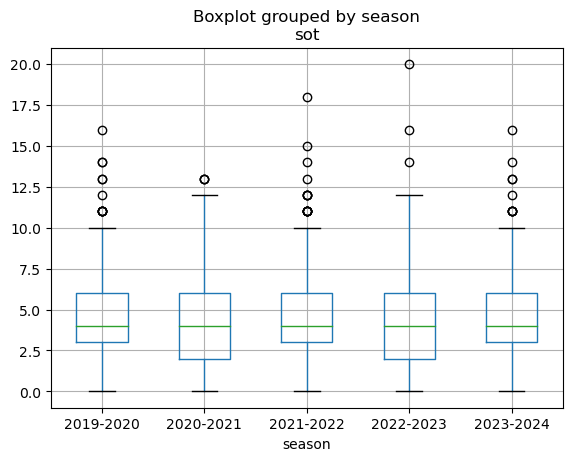

In [45]:
# boxplots of SOT per season
matches_dropped.boxplot(by='season', column='sot')

**save% = -100% is impossible**

<Axes: title={'center': 'save%'}, xlabel='season'>

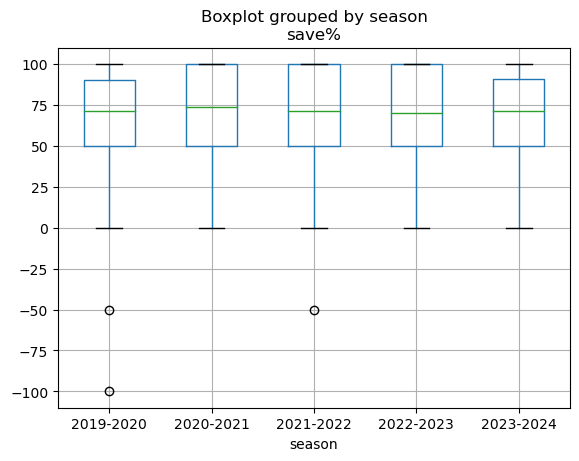

In [46]:
# boxplots of Save% per season
matches_dropped.boxplot(by='season', column='save%')

In [47]:
# check
matches_dropped.loc[matches_dropped.loc[:,'save%']<0,:][['date', 'team','opponent',
                                                               'venue', 'gf', 'ga', 'sot', 'saves', 'save%']]

,date,team,opponent,venue,gf,ga,sot,saves,save%
22,2022-01-22,Hoffenheim,Dortmund,Home,2.0,3.0,3.0,0.0,-50.0
10,2019-10-05,Dortmund,Freiburg,Away,2.0,2.0,4.0,0.0,-100.0
3,2019-08-31,Hertha BSC,Schalke 04,Away,0.0,3.0,3.0,1.0,-50.0


The reason is simple: the save% is calculated by (shots on target against - goals against)/(shots on target against). But in these matches, the goal against is greater than shots on target against due to some **own goals**. The formula should be 
save% = saves/shots on target against.

In [48]:
# a subset of matches_dropped which contain only important stats
df1 = matches_dropped.loc[:,['date', 'team', 'opponent','venue', 'sot', 'saves', 'save%' ]]
df1.head() 

,date,team,opponent,venue,sot,saves,save%
1,2023-08-19,Bayer Leverkusen,RB Leipzig,Home,7.0,4.0,66.7
2,2023-08-26,Bayer Leverkusen,Mönchengladbach,Away,11.0,2.0,100.0
3,2023-09-02,Bayer Leverkusen,Darmstadt 98,Home,13.0,0.0,0.0
4,2023-09-15,Bayer Leverkusen,Bayern Munich,Away,4.0,7.0,77.8
6,2023-09-24,Bayer Leverkusen,Heidenheim,Home,9.0,1.0,50.0


In [49]:
# find "shot on target against" by emerge
df2 = df1.merge(df1, left_on=['date', 'team'], right_on=['date', 'opponent'], suffixes=('', '_y'))
df2.head()

,date,team,opponent,venue,sot,saves,save%,team_y,opponent_y,venue_y,sot_y,saves_y,save%_y
0,2023-08-19,Bayer Leverkusen,RB Leipzig,Home,7.0,4.0,66.7,RB Leipzig,Bayer Leverkusen,Away,6.0,4.0,57.1
1,2023-08-26,Bayer Leverkusen,Mönchengladbach,Away,11.0,2.0,100.0,Mönchengladbach,Bayer Leverkusen,Home,2.0,8.0,72.7
2,2023-09-02,Bayer Leverkusen,Darmstadt 98,Home,13.0,0.0,0.0,Darmstadt 98,Bayer Leverkusen,Away,1.0,8.0,61.5
3,2023-09-15,Bayer Leverkusen,Bayern Munich,Away,4.0,7.0,77.8,Bayern Munich,Bayer Leverkusen,Home,9.0,3.0,80.0
4,2023-09-24,Bayer Leverkusen,Heidenheim,Home,9.0,1.0,50.0,Heidenheim,Bayer Leverkusen,Away,2.0,6.0,70.0


In [50]:
# filter negative save%
df3 = df2.loc[df2.loc[:,'save%']<0,:][['date', 'team','opponent','venue', 'sot', 'saves', 'save%', 'sot_y']]
df3.rename(columns={'sot_y':'sot_against'}, inplace=True)
df3

,date,team,opponent,venue,sot,saves,save%,sot_against
1281,2022-01-22,Hoffenheim,Dortmund,Home,3.0,0.0,-50.0,2.0
2254,2019-10-05,Dortmund,Freiburg,Away,4.0,0.0,-100.0,1.0
2522,2019-08-31,Hertha BSC,Schalke 04,Away,3.0,1.0,-50.0,2.0


In [51]:
(df3.loc[:,'saves']/df3.loc[:,'sot_against'])*100

1281     0.0
2254     0.0
2522    50.0
dtype: float64

In [52]:
# replace
matches_dropped.loc[matches_dropped.loc[:,'save%']<0,'save%'] = ((df3.loc[:,'saves']/df3.loc[:,'sot_against'])*100).values

In [53]:
# check
matches_dropped.loc[matches_dropped.loc[:,'save%']<0,:][['date', 'team','opponent',
                                                               'venue', 'gf', 'ga', 'sot', 'saves', 'save%']]

,date,team,opponent,venue,gf,ga,sot,saves,save%


In [54]:
# stats description of next numeric columns
matches_dropped.loc[:,["stp", "stp%", "#opa", 'cmp', 'att_x', "cmp%", 'totdist', 'prgdist','ast', 'kp','ppa']].describe()

,stp,stp%,#opa,cmp,att_x,cmp%,totdist,prgdist,ast,kp,ppa
count,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000
mean,0.683802,5.168488,1.401907,388.724399,501.448444,76.059050,7057.080990,2675.590094,1.110403,9.558097,7.759731
std,0.916449,7.537749,1.584358,128.518234,126.651926,7.043301,2089.486877,532.656707,1.135673,4.278925,4.255872
min,0.000000,0.000000,0.000000,106.000000,206.000000,45.100000,2342.000000,1218.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,294.000000,408.000000,71.700000,5517.250000,2298.000000,0.000000,7.000000,5.000000
50%,0.000000,0.000000,1.000000,371.000000,487.000000,76.600000,6803.500000,2643.000000,1.000000,9.000000,7.000000
75%,1.000000,8.700000,2.000000,470.000000,583.000000,81.400000,8451.000000,3009.750000,2.000000,12.000000,10.000000
max,6.000000,100.000000,13.000000,906.000000,1004.000000,93.200000,14704.000000,4688.000000,8.000000,31.000000,29.000000


In [55]:
# stats description of next numeric columns
matches_dropped.loc[:,['crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr',
       'touches', 'att_y', 'succ', 'succ%']].describe()

,crspa,tkl,tklw,blocks,int,clr,touches,att_y,succ,succ%
count,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000
mean,2.113020,16.055727,9.554494,11.681143,10.667728,19.360377,615.799685,16.780576,8.875346,52.581326
std,1.762969,5.133590,3.594889,3.994919,4.343849,8.712500,122.416921,6.508237,4.390587,15.710042
min,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,321.000000,3.000000,0.000000,0.000000
25%,1.000000,12.000000,7.000000,9.000000,8.000000,13.000000,526.000000,12.000000,6.000000,42.100000
50%,2.000000,16.000000,9.000000,11.000000,10.000000,18.000000,603.000000,16.000000,8.000000,53.300000
75%,3.000000,19.000000,12.000000,14.000000,13.000000,24.000000,691.750000,21.000000,11.000000,63.200000
max,13.000000,34.000000,24.000000,28.000000,29.000000,62.000000,1101.000000,46.000000,28.000000,100.000000


Everthing is fine till this step.

# Feature engineering

## add encoded columns

In [56]:
df = matches_dropped.copy()

In [57]:
# venue encode
venue_encoder = LabelEncoder()
df['venue_coded'] = venue_encoder.fit_transform(df['venue'])

In [58]:
# result encode
result_encoder = LabelEncoder()
df['result_encoded'] = result_encoder.fit_transform(df['result'])

In [59]:
df[['result', 'result_encoded']]

,result,result_encoded
1,W,2
2,W,2
3,W,2
4,D,0
6,W,2
...,...,...
31,D,0
32,L,1
33,L,1
34,L,1


- Win = 2
- Draw = 0
- Lose = 1

In [60]:
# opponent encode
opponent_encoder = LabelEncoder()
df['opponent_encoded'] = opponent_encoder.fit_transform(df['opponent'])

In [61]:
# team encode
df['team_encoded'] = opponent_encoder.transform(df['team'])

In [62]:
df.shape

(2826, 43)

## Average stats last k games

We will base on the performance of the last k games of each team to predict the next outcome of a match.

In [63]:
def average_stats_last_games(group, stats, name_of_average_stats,k=4):
    group = group.sort_values('date')
    average_stats_last_k_games = group[stats].rolling(k, closed='left').mean()
    group[name_of_average_stats] = average_stats_last_k_games
    group = group.dropna(subset=name_of_average_stats)
    return group

In [64]:
# choose stats and name of average stats
stats = numeric_col
name_of_average_stats = [f"{c}_average" for c in stats]

In [65]:
# compute average stats for each team
df_average = df.groupby('team').apply(lambda x: average_stats_last_games(x, stats, name_of_average_stats))
# remove level "team"
df_average = df_average.droplevel('team')
# sort dates
df_average.sort_values('date', inplace=True)
# rearrange index
df_average.index = range(df_average.shape[0])
# show first rows
df_average.head()

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,crspa_average,tkl_average,tklw_average,blocks_average,int_average,clr_average,touches_average,att_y_average,succ_average,succ%_average
0,2019-09-20,Bundesliga,Matchweek 5,Away,L,1.0,2.0,Schalke 04,0.8,1.0,...,1.50,17.75,11.25,11.25,11.50,21.50,528.75,15.25,7.75,49.675
1,2019-09-20,Bundesliga,Matchweek 5,Home,W,2.0,1.0,Mainz 05,1.0,0.8,...,1.75,20.00,13.75,14.50,11.75,18.00,567.25,13.50,8.25,63.775
2,2019-09-21,Bundesliga,Matchweek 5,Away,D,1.0,1.0,Freiburg,1.0,1.3,...,2.25,17.50,10.75,9.75,14.25,28.50,443.75,10.75,5.75,53.025
3,2019-09-21,Bundesliga,Matchweek 5,Home,L,0.0,3.0,RB Leipzig,0.7,1.5,...,1.25,11.50,8.00,7.00,5.75,15.75,650.00,9.50,6.00,63.825
4,2019-09-21,Bundesliga,Matchweek 5,Away,W,3.0,0.0,Werder Bremen,1.5,0.7,...,1.25,19.75,11.50,11.75,13.50,26.00,632.75,18.25,12.00,65.650


In [66]:
# full stats
df_full = df_average.merge(df_average, left_on=['date', 'team'], 
                                right_on=['date', 'opponent'], suffixes=('', '_opponent'))
df_full.head()

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,crspa_average_opponent,tkl_average_opponent,tklw_average_opponent,blocks_average_opponent,int_average_opponent,clr_average_opponent,touches_average_opponent,att_y_average_opponent,succ_average_opponent,succ%_average_opponent
0,2019-09-20,Bundesliga,Matchweek 5,Away,L,1.0,2.0,Schalke 04,0.8,1.0,...,1.75,20.00,13.75,14.50,11.75,18.00,567.25,13.50,8.25,63.775
1,2019-09-20,Bundesliga,Matchweek 5,Home,W,2.0,1.0,Mainz 05,1.0,0.8,...,1.50,17.75,11.25,11.25,11.50,21.50,528.75,15.25,7.75,49.675
2,2019-09-21,Bundesliga,Matchweek 5,Away,D,1.0,1.0,Freiburg,1.0,1.3,...,2.00,14.75,8.25,11.75,6.50,19.25,505.00,16.00,9.50,59.925
3,2019-09-21,Bundesliga,Matchweek 5,Home,L,0.0,3.0,RB Leipzig,0.7,1.5,...,1.25,19.75,11.50,11.75,13.50,26.00,632.75,18.25,12.00,65.650
4,2019-09-21,Bundesliga,Matchweek 5,Away,W,3.0,0.0,Werder Bremen,1.5,0.7,...,1.25,11.50,8.00,7.00,5.75,15.75,650.00,9.50,6.00,63.825


In [67]:
df_full.shape

(2706, 147)

## Train test split

In [68]:
# train test
train = df_full.loc[:int(df_full.shape[0]*0.7)]
test = df_full.loc[int(df_full.shape[0]*0.7)+1:]

## EDA

In [69]:
numeric_col

Index(['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%',
       'stp', 'stp%', '#opa', 'cmp', 'att_x', 'cmp%', 'totdist', 'prgdist',
       'ast', 'kp', 'ppa', 'crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr',
       'touches', 'att_y', 'succ', 'succ%'],
      dtype='object')

In [70]:
name_of_average_stats

['gf_average',
 'ga_average',
 'xg_average',
 'xga_average',
 'poss_average',
 'sh_average',
 'sot_average',
 'sot%_average',
 'saves_average',
 'save%_average',
 'stp_average',
 'stp%_average',
 '#opa_average',
 'cmp_average',
 'att_x_average',
 'cmp%_average',
 'totdist_average',
 'prgdist_average',
 'ast_average',
 'kp_average',
 'ppa_average',
 'crspa_average',
 'tkl_average',
 'tklw_average',
 'blocks_average',
 'int_average',
 'clr_average',
 'touches_average',
 'att_y_average',
 'succ_average',
 'succ%_average']

In [71]:
len(numeric_col)==len(name_of_average_stats)

True

In [72]:
train[name_of_average_stats]

,gf_average,ga_average,xg_average,xga_average,poss_average,sh_average,sot_average,sot%_average,saves_average,save%_average,...,crspa_average,tkl_average,tklw_average,blocks_average,int_average,clr_average,touches_average,att_y_average,succ_average,succ%_average
0,1.0,3.25,1.175,2.325,45.00,14.50,4.50,36.275,4.50,61.450,...,1.50,17.75,11.25,11.25,11.50,21.50,528.75,15.25,7.75,49.675
1,2.0,1.00,1.275,1.175,46.25,11.25,4.00,29.400,2.50,66.675,...,1.75,20.00,13.75,14.50,11.75,18.00,567.25,13.50,8.25,63.775
2,1.5,2.50,1.275,1.925,35.25,9.25,4.00,41.450,2.25,50.275,...,2.25,17.50,10.75,9.75,14.25,28.50,443.75,10.75,5.75,53.025
3,2.0,2.25,1.900,1.250,58.00,17.75,6.25,34.625,3.00,55.950,...,1.25,11.50,8.00,7.00,5.75,15.75,650.00,9.50,6.00,63.825
4,2.5,0.75,2.300,1.250,47.75,12.75,5.75,44.525,3.50,83.100,...,1.25,19.75,11.50,11.75,13.50,26.00,632.75,18.25,12.00,65.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,1.0,1.50,1.850,1.125,52.00,15.50,6.25,39.775,4.75,78.125,...,1.75,12.50,6.00,11.75,7.50,23.75,629.50,22.25,10.50,47.300
1891,1.0,0.75,1.050,0.800,43.50,12.50,3.25,25.775,2.50,83.325,...,4.00,20.75,12.50,11.50,7.50,16.50,555.75,12.75,5.25,43.500
1892,1.5,1.00,1.325,0.950,45.00,12.50,4.75,40.250,2.00,71.250,...,1.00,16.50,9.25,11.25,11.75,21.25,529.50,20.00,6.00,28.775
1893,2.0,1.50,1.825,1.300,52.25,16.00,5.00,31.325,2.50,68.750,...,3.00,17.25,10.75,11.75,8.50,21.25,610.50,17.50,7.00,38.600


In [73]:
corr_matrix = train[name_of_average_stats].corr()

In [74]:
corr_matrix

,gf_average,ga_average,xg_average,xga_average,poss_average,sh_average,sot_average,sot%_average,saves_average,save%_average,...,crspa_average,tkl_average,tklw_average,blocks_average,int_average,clr_average,touches_average,att_y_average,succ_average,succ%_average
gf_average,1.000000,-0.294393,0.737042,-0.360235,0.422408,0.494102,0.708846,0.511765,-0.221413,0.107003,...,0.077798,0.006919,0.023041,-0.104142,-0.111710,-0.306983,0.460908,0.224932,0.282505,0.192776
ga_average,-0.294393,1.000000,-0.285359,0.667568,-0.220743,-0.213605,-0.272583,-0.181981,0.229484,-0.601383,...,-0.077653,-0.008332,0.015249,0.007201,0.052670,0.061264,-0.245140,-0.027640,-0.058905,-0.089301
xg_average,0.737042,-0.285359,1.000000,-0.336929,0.541342,0.750660,0.783258,0.337580,-0.227003,0.090137,...,0.256738,-0.001653,0.022216,-0.150103,-0.158054,-0.432705,0.538307,0.322317,0.394007,0.267265
xga_average,-0.360235,0.667568,-0.336929,1.000000,-0.370593,-0.298953,-0.326463,-0.175852,0.549922,-0.156787,...,-0.114209,0.008640,0.020896,0.195568,0.071800,0.262876,-0.369802,-0.064732,-0.111490,-0.143423
poss_average,0.422408,-0.220743,0.541342,-0.370593,1.000000,0.590196,0.527007,0.136112,-0.329294,0.012313,...,0.208765,-0.125816,-0.075159,-0.302808,-0.328410,-0.656887,0.936786,0.454363,0.485107,0.241658
sh_average,0.494102,-0.213605,0.750660,-0.298953,0.590196,1.000000,0.798332,0.109172,-0.243660,0.015471,...,0.368369,-0.012048,0.027765,-0.171519,-0.217037,-0.492102,0.533084,0.347144,0.389309,0.201981
sot_average,0.708846,-0.272583,0.783258,-0.326463,0.527007,0.798332,1.000000,0.625883,-0.233647,0.061736,...,0.210568,0.003655,0.035703,-0.132922,-0.170773,-0.405726,0.524917,0.334571,0.378289,0.202883
sot%_average,0.511765,-0.181981,0.337580,-0.175852,0.136112,0.109172,0.625883,1.000000,-0.097083,0.068775,...,-0.086125,0.020644,0.021297,0.018784,-0.017929,-0.035564,0.188783,0.086889,0.121757,0.095649
saves_average,-0.221413,0.229484,-0.227003,0.549922,-0.329294,-0.243660,-0.233647,-0.097083,1.000000,0.309494,...,-0.113836,0.051633,0.020234,0.217753,0.097334,0.326326,-0.327115,-0.071070,-0.110894,-0.142935
save%_average,0.107003,-0.601383,0.090137,-0.156787,0.012313,0.015471,0.061736,0.068775,0.309494,1.000000,...,-0.015519,0.005812,-0.011631,0.072440,0.010005,0.077004,0.033210,-0.020006,0.010597,0.040058


In [99]:
for i in corr_matrix.columns:
    print(corr_matrix.loc[(corr_matrix.loc[:, i]>0.7)|(corr_matrix.loc[:, i]<-0.7),i], "\n")

gf_average     1.000000
xg_average     0.737042
sot_average    0.708846
ast_average    0.894480
Name: gf_average, dtype: float64 

ga_average    1.0
Name: ga_average, dtype: float64 

gf_average     0.737042
xg_average     1.000000
sh_average     0.750660
sot_average    0.783258
kp_average     0.765820
Name: xg_average, dtype: float64 

xga_average    1.0
Name: xga_average, dtype: float64 

poss_average       1.000000
cmp_average        0.929036
att_x_average      0.939256
cmp%_average       0.840756
totdist_average    0.927215
prgdist_average    0.894192
ppa_average        0.701798
touches_average    0.936786
Name: poss_average, dtype: float64 

xg_average     0.750660
sh_average     1.000000
sot_average    0.798332
kp_average     0.944036
ppa_average    0.719094
Name: sh_average, dtype: float64 

gf_average     0.708846
xg_average     0.783258
sh_average     0.798332
sot_average    1.000000
kp_average     0.804959
Name: sot_average, dtype: float64 

sot%_average    1.0
Name: sot%_ave

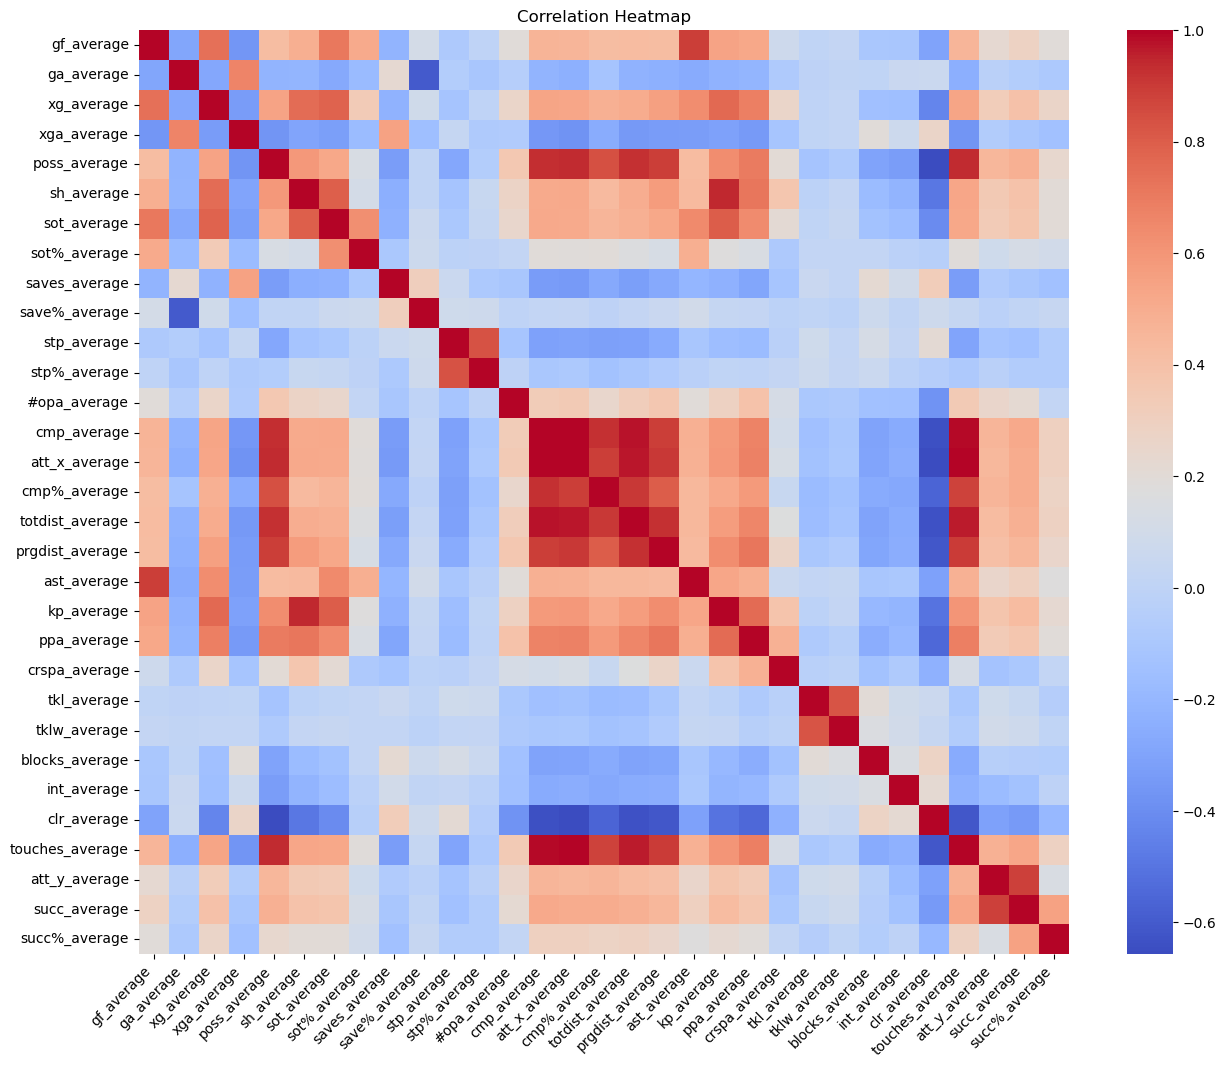

In [83]:
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(corr_matrix, cmap='coolwarm') #, annot=True
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Heatmap')
plt.show()

Some conclusions:
- gf_average and xg_average, sot_average, ast_average
- xg_average with gf_average, sh_average     0.737042
     1.000000
     0.750660
sot_average    0.783258
kp_average     0.765820
- poss_avg and cmp_avg, cmp%_avg, att_x_avg, totdist_avg, prgdist_avg, ppa_avg, touches_avg


In [101]:
# selected stats
selected_stats = ['gf_average', 'poss_average', 'sot%_average', 'saves_average', 'save%_average', 'stp_average',
                  '#opa_average', 'kp_average', 'crspa_average', 'tkl_average', 'blocks_average',
                  'int_average', 'clr_average', 'att_y_average', 'succ%_average']

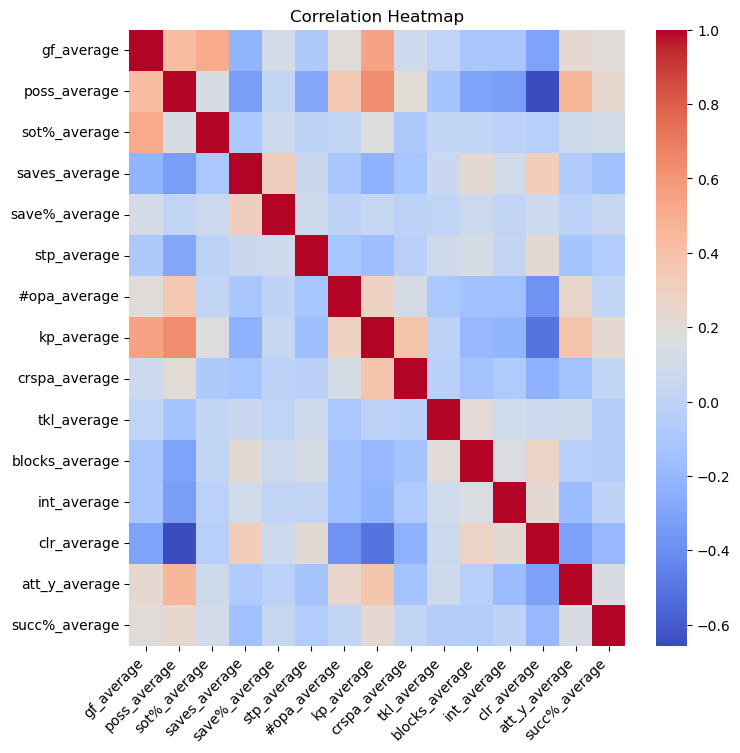

In [106]:
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(train[selected_stats].corr(), cmap='coolwarm') #, annot=True
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Heatmap')
plt.show()

**there are also ga_avg and xga_avg**, need to check corr with opponent stats

## Choose predictors

In [250]:
# create list of corresponding stats of opponent
new_cols_opponent = [f"{stat}_opponent" for stat in new_cols]
new_cols_opponent

['gf_average_opponent',
 'ga_average_opponent',
 'poss_average_opponent',
 'sot_average_opponent',
 'sot%_average_opponent',
 'saves_average_opponent',
 'ast_average_opponent',
 'tklw_average_opponent',
 'blocks_average_opponent',
 'clr_average_opponent']

In [ ]:
# predictors
predictors = ['team_encoded', 'opponent_encoded', 'venue_coded'] + new_cols + new_cols_opponent
predictors

# Test models

## test for season 2022-2023

In [63]:
df_2022 = df.loc[df.loc[:,'season']=='2022-2023']
df_2022.sort_values(by='date')
df_2022.index = range(df_2022.shape[0])
df_2022

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,touches,att_y,succ,succ%,season,team,venue_coded,result_encoded,opponent_encoded,team_encoded
0,2022-08-05,Bundesliga,Matchweek 1,Away,W,6.0,1.0,Eintracht Frankfurt,4.0,0.9,...,784.0,20.0,9.0,45.0,2022-2023,Bayern Munich,0,2,8,3
1,2022-08-14,Bundesliga,Matchweek 2,Home,W,2.0,0.0,Wolfsburg,2.0,0.5,...,759.0,19.0,11.0,57.9,2022-2023,Bayern Munich,1,2,23,3
2,2022-08-21,Bundesliga,Matchweek 3,Away,W,7.0,0.0,Bochum,2.9,0.7,...,649.0,19.0,11.0,57.9,2022-2023,Bayern Munich,0,2,4,3
3,2022-08-27,Bundesliga,Matchweek 4,Home,D,1.0,1.0,Mönchengladbach,2.8,0.5,...,793.0,27.0,14.0,51.9,2022-2023,Bayern Munich,1,0,16,3
4,2022-09-03,Bundesliga,Matchweek 5,Away,D,1.0,1.0,Union Berlin,1.5,0.3,...,896.0,35.0,11.0,31.4,2022-2023,Bayern Munich,0,0,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2023-04-30,Bundesliga,Matchweek 30,Away,L,0.0,2.0,Bayern Munich,0.1,2.7,...,340.0,20.0,11.0,55.0,2022-2023,Hertha BSC,0,1,3,12
608,2023-05-06,Bundesliga,Matchweek 31,Home,W,2.0,1.0,Stuttgart,1.2,1.5,...,402.0,20.0,12.0,60.0,2022-2023,Hertha BSC,1,2,20,12
609,2023-05-12,Bundesliga,Matchweek 32,Away,L,2.0,5.0,Köln,1.1,4.3,...,461.0,25.0,14.0,56.0,2022-2023,Hertha BSC,0,1,14,12
610,2023-05-20,Bundesliga,Matchweek 33,Home,D,1.0,1.0,Bochum,1.2,1.1,...,503.0,25.0,16.0,64.0,2022-2023,Hertha BSC,1,0,4,12


In [64]:
df_2022.columns

Index(['date', 'comp', 'round', 'venue', 'result', 'gf', 'ga', 'opponent',
       'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'saves', 'save%', 'stp',
       'stp%', '#opa', 'cmp', 'att_x', 'cmp%', 'totdist', 'prgdist', 'ast',
       'kp', 'ppa', 'crspa', 'tkl', 'tklw', 'blocks', 'int', 'clr', 'touches',
       'att_y', 'succ', 'succ%', 'season', 'team', 'venue_coded',
       'result_encoded', 'opponent_encoded', 'team_encoded'],
      dtype='object')

In [65]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('date')
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [66]:
# choose some stats to check
cols = ['gf', 'ga', 'poss', 'sot', 'sot%', 'saves', 'ast', 'tklw', 'blocks','clr']
new_cols = [f"{c}_rolling" for c in cols]

**Description:**

Match stats:
- gf = goals for
- ga = goals against
- xg = expected goals
- xga = expected goals allowed
- poss = possession, calculated as the percentage of passess attempted

Shooting:
- sh = shots total
- sot = shots on target
- sot% = shots on target %

Goalkeeping:
- saves = number of saves
- save% = save percentage
- stp = number of crosses into penalty area which was succesfully stopped by the goalkeeper
- stp% = crosses stopped %
- #opa = number of defensive action outside of penalty area

Passing:
- cmp = passes completed
- att_x = passes attempted
- cmp% = pass completion %
- totdist = total distance in yards, that completed passes have traveled in any direction
- prgdist = total distance in yards, that completed passes have traveled towards opponents's goal
- ast = assists
- kp = key passes, directly lead to a shot
- ppa = passes into penalty area
- crspa = crosses into penalty area

Defence:
- tkl = tackles
- tklw = tackles won
- blocks = number of times blocking the ball by standing in its path
- int = interceptions
- clr = clearances

Possession:
- touches = number of times a player touches the ball
- att_y = take-ons attempted
- succ = succesful take-ons
- succ% = succesful take-ons %

In [67]:
df_2022_rolling = df_2022.groupby('team').apply(lambda x: rolling_averages(x, cols, new_cols))
df_2022_rolling

date        comp         round venue result   gf   ga  \
team                                                                         
Augsburg  481  2022-09-09  Bundesliga   Matchweek 6  Away      W  1.0  0.0   
          482  2022-09-17  Bundesliga   Matchweek 7  Home      W  1.0  0.0   
          483  2022-10-02  Bundesliga   Matchweek 8  Away      W  3.0  2.0   
          484  2022-10-08  Bundesliga   Matchweek 9  Home      D  1.0  1.0   
          485  2022-10-16  Bundesliga  Matchweek 10  Away      L  2.0  3.0   
...                   ...         ...           ...   ...    ...  ...  ...   
Wolfsburg 267  2023-04-30  Bundesliga  Matchweek 30  Home      W  3.0  0.0   
          268  2023-05-07  Bundesliga  Matchweek 31  Away      L  0.0  6.0   
          269  2023-05-13  Bundesliga  Matchweek 32  Home      W  2.0  1.0   
          270  2023-05-19  Bundesliga  Matchweek 33  Away      L  0.0  2.0   
          271  2023-05-27  Bundesliga  Matchweek 34  Home      L  1.0  2.0   

                    opponent   xg  xga  ...  gf_rolling  ga_rolling  \
team                                    ...                           
Augsburg  481  Werder Bremen  1.0  1.3  ...         0.6         2.0   
          482  Bayern Munich  1.7  1.6  ...         0.8         1.2   
          483     Schalke 04  1.4  1.8  ...         0.6         1.0   
          484      Wolfsburg  2.0  1.8  ...         1.0         1.0   
          485           Köln  0.4  1.5  ...         1.2         1.0   
...                      ...  ...  ...  ...         ...         ...   
Wolfsburg 267       Mainz 05  1.9  1.7  ...         1.6         1.0   
          268       Dortmund  1.2  4.2  ...         2.0         1.0   
          269     Hoffenheim  1.1  1.0  ...         1.6         1.8   
          270       Freiburg  0.7  1.3  ...         2.0         1.6   
          271     Hertha BSC  3.4  2.1  ...         2.0         2.0   

               poss_rolling  sot_rolling  sot%_rolling  saves_rolling  \
team                                                                    
Augsburg  481          47.0          2.0         27.38            4.6   
          482          42.8          2.8         31.74            5.2   
          483          40.8          2.8         26.40            4.6   
          484          39.6          3.6         30.68            4.8   
          485          39.4          4.4         34.74            5.2   
...                     ...          ...           ...            ...   
Wolfsburg 267          51.0          4.0         30.66            3.2   
          268          52.6          4.2         32.00            3.2   
          269          47.6          3.8         33.46            3.8   
          270          45.6          4.0         36.12            3.4   
          271          48.4          3.8         35.10            3.6   

               ast_rolling  tklw_rolling  blocks_rolling  clr_rolling  
team                                                                   
Augsburg  481          0.4          10.8            10.0         20.8  
          482          0.6           9.4            10.2         20.8  
          483          0.6           9.8            10.8         19.4  
          484          0.8           9.2            12.8         24.0  
          485          0.8           8.4            12.0         24.4  
...                    ...           ...             ...          ...  
Wolfsburg 267          1.2          11.2            16.0         18.8  
          268          1.6          11.0            17.0         17.4  
          269          1.2          12.6            17.4         19.2  
          270          1.6          11.6            16.0         21.8  
          271          1.6          11.4            14.2         21.6  

[522 rows x 53 columns]

In [68]:
df_2022_rolling = df_2022_rolling.droplevel('team')
df_2022_rolling.sort_values('date', inplace=True)
df_2022_rolling.index = range(df_2022_rolling.shape[0])
df_2022_rolling

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,gf_rolling,ga_rolling,poss_rolling,sot_rolling,sot%_rolling,saves_rolling,ast_rolling,tklw_rolling,blocks_rolling,clr_rolling
0,2022-09-09,Bundesliga,Matchweek 6,Away,W,1.0,0.0,Werder Bremen,1.0,1.3,...,0.6,2.0,47.0,2.0,27.38,4.6,0.4,10.8,10.0,20.8
1,2022-09-09,Bundesliga,Matchweek 6,Home,L,0.0,1.0,Augsburg,1.3,1.0,...,2.4,2.0,50.0,4.6,44.66,3.0,1.6,10.4,12.4,22.0
2,2022-09-10,Bundesliga,Matchweek 6,Home,W,4.0,1.0,Mainz 05,4.2,0.7,...,1.6,1.2,48.6,4.8,40.48,3.0,1.2,9.2,13.2,14.6
3,2022-09-10,Bundesliga,Matchweek 6,Home,L,0.0,1.0,Wolfsburg,0.7,1.0,...,2.2,2.2,48.4,4.0,37.78,2.0,1.2,10.0,9.2,16.8
4,2022-09-10,Bundesliga,Matchweek 6,Away,L,1.0,4.0,Hoffenheim,0.7,4.2,...,1.0,1.0,49.6,4.6,37.30,1.8,0.8,7.8,13.6,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2023-05-27,Bundesliga,Matchweek 34,Home,W,4.0,2.0,Schalke 04,2.6,1.2,...,1.4,0.8,57.6,4.8,29.54,1.8,0.6,8.2,11.0,15.2
518,2023-05-27,Bundesliga,Matchweek 34,Away,L,2.0,4.0,RB Leipzig,1.2,2.6,...,1.4,3.0,48.6,5.2,36.46,3.4,1.2,9.4,10.0,19.6
519,2023-05-27,Bundesliga,Matchweek 34,Home,D,1.0,1.0,Hoffenheim,2.5,0.8,...,1.8,1.2,55.8,3.4,36.44,2.0,1.0,7.4,9.8,17.4
520,2023-05-27,Bundesliga,Matchweek 34,Away,W,2.0,1.0,Wolfsburg,2.1,3.4,...,1.4,2.6,38.2,2.8,35.68,4.8,1.0,10.0,10.8,28.8


In [69]:
df_test_2022 = df_2022_rolling.merge(df_2022_rolling, left_on=['date', 'team'], 
                                right_on=['date', 'opponent'], suffixes=('', '_y'))

In [70]:
df_test_2022

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,gf_rolling_y,ga_rolling_y,poss_rolling_y,sot_rolling_y,sot%_rolling_y,saves_rolling_y,ast_rolling_y,tklw_rolling_y,blocks_rolling_y,clr_rolling_y
0,2022-09-09,Bundesliga,Matchweek 6,Away,W,1.0,0.0,Werder Bremen,1.0,1.3,...,2.4,2.0,50.0,4.6,44.66,3.0,1.6,10.4,12.4,22.0
1,2022-09-09,Bundesliga,Matchweek 6,Home,L,0.0,1.0,Augsburg,1.3,1.0,...,0.6,2.0,47.0,2.0,27.38,4.6,0.4,10.8,10.0,20.8
2,2022-09-10,Bundesliga,Matchweek 6,Home,W,4.0,1.0,Mainz 05,4.2,0.7,...,1.0,1.0,49.6,4.6,37.30,1.8,0.8,7.8,13.6,14.4
3,2022-09-10,Bundesliga,Matchweek 6,Home,L,0.0,1.0,Wolfsburg,0.7,1.0,...,0.8,2.0,54.4,3.6,33.06,3.2,0.6,8.4,12.4,18.8
4,2022-09-10,Bundesliga,Matchweek 6,Away,L,1.0,4.0,Hoffenheim,0.7,4.2,...,1.6,1.2,48.6,4.8,40.48,3.0,1.2,9.2,13.2,14.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2023-05-27,Bundesliga,Matchweek 34,Home,W,4.0,2.0,Schalke 04,2.6,1.2,...,1.4,3.0,48.6,5.2,36.46,3.4,1.2,9.4,10.0,19.6
518,2023-05-27,Bundesliga,Matchweek 34,Away,L,2.0,4.0,RB Leipzig,1.2,2.6,...,1.4,0.8,57.6,4.8,29.54,1.8,0.6,8.2,11.0,15.2
519,2023-05-27,Bundesliga,Matchweek 34,Home,D,1.0,1.0,Hoffenheim,2.5,0.8,...,1.8,1.8,44.8,2.8,32.12,2.2,0.8,9.0,11.4,24.4
520,2023-05-27,Bundesliga,Matchweek 34,Away,W,2.0,1.0,Wolfsburg,2.1,3.4,...,2.0,2.0,48.4,3.8,35.10,3.6,1.6,11.4,14.2,21.6


In [71]:
558*0.7

390.59999999999997

In [72]:
# train test
train = df_test_2022.loc[:390]
test = df_test_2022.loc[390:]

In [73]:
# new train test
# train = df_test.loc[df_test['date']<'2023-10-01']
# test = df_test.loc[df_test['date']>'2023-09-30']

In [74]:
test

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,gf_rolling_y,ga_rolling_y,poss_rolling_y,sot_rolling_y,sot%_rolling_y,saves_rolling_y,ast_rolling_y,tklw_rolling_y,blocks_rolling_y,clr_rolling_y
390,2023-04-09,Bundesliga,Matchweek 27,Home,L,2.0,3.0,Stuttgart,2.4,2.2,...,0.6,1.8,54.2,4.2,31.46,2.6,0.6,10.8,13.8,20.6
391,2023-04-09,Bundesliga,Matchweek 27,Away,L,0.0,2.0,Hoffenheim,0.7,2.2,...,1.2,1.2,45.8,3.0,23.96,4.6,0.6,12.6,13.2,23.0
392,2023-04-09,Bundesliga,Matchweek 27,Away,W,3.0,2.0,Bochum,2.2,2.4,...,0.8,1.2,40.2,2.2,30.00,4.8,0.4,13.0,12.2,35.2
393,2023-04-09,Bundesliga,Matchweek 27,Home,W,2.0,0.0,Wolfsburg,1.6,1.5,...,1.6,1.0,52.8,4.6,41.20,1.8,1.4,9.2,11.2,21.4
394,2023-04-09,Bundesliga,Matchweek 27,Away,L,0.0,2.0,Mönchengladbach,1.5,1.6,...,0.4,1.8,51.4,3.4,30.38,3.8,0.2,8.4,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2023-05-27,Bundesliga,Matchweek 34,Home,W,4.0,2.0,Schalke 04,2.6,1.2,...,1.4,3.0,48.6,5.2,36.46,3.4,1.2,9.4,10.0,19.6
518,2023-05-27,Bundesliga,Matchweek 34,Away,L,2.0,4.0,RB Leipzig,1.2,2.6,...,1.4,0.8,57.6,4.8,29.54,1.8,0.6,8.2,11.0,15.2
519,2023-05-27,Bundesliga,Matchweek 34,Home,D,1.0,1.0,Hoffenheim,2.5,0.8,...,1.8,1.8,44.8,2.8,32.12,2.2,0.8,9.0,11.4,24.4
520,2023-05-27,Bundesliga,Matchweek 34,Away,W,2.0,1.0,Wolfsburg,2.1,3.4,...,2.0,2.0,48.4,3.8,35.10,3.6,1.6,11.4,14.2,21.6


In [75]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=10)

In [76]:
new_cols_opponent = [f"{stat}_y" for stat in new_cols]
new_cols_opponent

['gf_rolling_y',
 'ga_rolling_y',
 'poss_rolling_y',
 'sot_rolling_y',
 'sot%_rolling_y',
 'saves_rolling_y',
 'ast_rolling_y',
 'tklw_rolling_y',
 'blocks_rolling_y',
 'clr_rolling_y']

In [77]:
# predictors
predictors = ['team_encoded', 'venue_coded', 'opponent_encoded'] + new_cols + new_cols_opponent
predictors

['team_encoded',
 'venue_coded',
 'opponent_encoded',
 'gf_rolling',
 'ga_rolling',
 'poss_rolling',
 'sot_rolling',
 'sot%_rolling',
 'saves_rolling',
 'ast_rolling',
 'tklw_rolling',
 'blocks_rolling',
 'clr_rolling',
 'gf_rolling_y',
 'ga_rolling_y',
 'poss_rolling_y',
 'sot_rolling_y',
 'sot%_rolling_y',
 'saves_rolling_y',
 'ast_rolling_y',
 'tklw_rolling_y',
 'blocks_rolling_y',
 'clr_rolling_y']

In [78]:
rf.fit(train[predictors], train['result_encoded'])

RandomForestClassifier(min_samples_split=5, random_state=10)

In [79]:
prob_preds = rf.predict_proba(test[predictors])
preds = rf.predict(test[predictors])

In [80]:
accuracy_score(test['result_encoded'], preds)

0.5303030303030303

In [81]:
combined = pd.DataFrame(dict(actual=test['result_encoded'], prediction = preds))
combined

,actual,prediction
390,1,1
391,1,1
392,2,1
393,2,2
394,1,1
...,...,...
517,2,2
518,1,1
519,0,2
520,2,1


In [82]:
pd.crosstab(index=combined['actual'], columns=combined['prediction'])

prediction,0,1,2
actual,,,
0,1,17,16
1,0,36,13
2,0,16,33


In [83]:
# precision_score(test['result_encoded'], preds): doesnt work

In [84]:
a= test[['team', 'opponent', 'venue', 'gf_rolling', 
 'ga_rolling',
  'sot_rolling',
  'gf_rolling_y',
 'ga_rolling_y',
 'sot_rolling_y',
 'result', 'gf', 'ga']]
a = a.assign(Draw_prob=prob_preds[:,0],Lose_prob = prob_preds[:,1],Win_prob = prob_preds[:,2], Prediction = preds )
a

,team,opponent,venue,gf_rolling,ga_rolling,sot_rolling,gf_rolling_y,ga_rolling_y,sot_rolling_y,result,gf,ga,Draw_prob,Lose_prob,Win_prob,Prediction
390,Bochum,Stuttgart,Home,0.8,1.2,2.2,0.6,1.8,4.2,L,2.0,3.0,0.072619,0.783365,0.144016,1
391,Schalke 04,Hoffenheim,Away,1.4,1.4,4.2,1.2,1.2,3.0,L,0.0,2.0,0.221853,0.587238,0.190909,1
392,Stuttgart,Bochum,Away,0.6,1.8,4.2,0.8,1.2,2.2,W,3.0,2.0,0.226917,0.493242,0.279841,1
393,Mönchengladbach,Wolfsburg,Home,0.4,1.8,3.4,1.6,1.0,4.6,W,2.0,0.0,0.251238,0.328012,0.420750,2
394,Wolfsburg,Mönchengladbach,Away,1.6,1.0,4.6,0.4,1.8,3.4,L,0.0,2.0,0.239094,0.443683,0.317223,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,RB Leipzig,Schalke 04,Home,1.4,0.8,4.8,1.4,3.0,5.2,W,4.0,2.0,0.183274,0.184131,0.632595,2
518,Schalke 04,RB Leipzig,Away,1.4,3.0,5.2,1.4,0.8,4.8,L,2.0,4.0,0.115881,0.694762,0.189357,1
519,Stuttgart,Hoffenheim,Home,1.8,1.2,3.4,1.8,1.8,2.8,D,1.0,1.0,0.182929,0.186524,0.630548,2
520,Hertha BSC,Wolfsburg,Away,1.4,2.6,2.8,2.0,2.0,3.8,W,2.0,1.0,0.257234,0.418333,0.324433,1


In [85]:
prob_preds[0]

array([0.07261905, 0.78336508, 0.14401587])

- Win = 2
- Draw = 0
- Lose = 1

## test for all

In [86]:
df

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,touches,att_y,succ,succ%,season,team,venue_coded,result_encoded,opponent_encoded,team_encoded
1,2023-08-19,Bundesliga,Matchweek 1,Home,W,3.0,2.0,RB Leipzig,1.4,1.6,...,574.0,22.0,11.0,50.0,2023-2024,Bayer Leverkusen,1,2,18,2
2,2023-08-26,Bundesliga,Matchweek 2,Away,W,3.0,0.0,Mönchengladbach,2.7,0.9,...,854.0,16.0,7.0,43.8,2023-2024,Bayer Leverkusen,0,2,16,2
3,2023-09-02,Bundesliga,Matchweek 3,Home,W,5.0,1.0,Darmstadt 98,2.8,0.4,...,913.0,26.0,15.0,57.7,2023-2024,Bayer Leverkusen,1,2,5,2
4,2023-09-15,Bundesliga,Matchweek 4,Away,D,2.0,2.0,Bayern Munich,2.1,2.1,...,744.0,33.0,16.0,48.5,2023-2024,Bayer Leverkusen,0,0,3,2
6,2023-09-24,Bundesliga,Matchweek 5,Home,W,4.0,1.0,Heidenheim,3.4,0.5,...,964.0,23.0,14.0,60.9,2023-2024,Bayer Leverkusen,1,2,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,2020-06-06,Bundesliga,Matchweek 30,Away,D,1.0,1.0,RB Leipzig,1.1,1.4,...,588.0,15.0,12.0,80.0,2019-2020,Paderborn 07,0,0,18,17
32,2020-06-13,Bundesliga,Matchweek 31,Home,L,1.0,5.0,Werder Bremen,1.6,2.9,...,532.0,14.0,9.0,64.3,2019-2020,Paderborn 07,1,1,22,17
33,2020-06-16,Bundesliga,Matchweek 32,Away,L,0.0,1.0,Union Berlin,0.5,1.4,...,650.0,22.0,13.0,59.1,2019-2020,Paderborn 07,0,1,21,17
34,2020-06-20,Bundesliga,Matchweek 33,Home,L,1.0,3.0,Mönchengladbach,0.7,3.5,...,578.0,22.0,9.0,40.9,2019-2020,Paderborn 07,1,1,16,17


In [87]:
cols

['gf', 'ga', 'poss', 'sot', 'sot%', 'saves', 'ast', 'tklw', 'blocks', 'clr']

In [88]:
new_cols

['gf_rolling',
 'ga_rolling',
 'poss_rolling',
 'sot_rolling',
 'sot%_rolling',
 'saves_rolling',
 'ast_rolling',
 'tklw_rolling',
 'blocks_rolling',
 'clr_rolling']

In [89]:
df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x, cols, new_cols))
df_rolling

date        comp         round venue result   gf   ga  \
team                                                                        
Arminia   6   2020-10-31  Bundesliga   Matchweek 6  Home      L  0.0  2.0   
          7   2020-11-07  Bundesliga   Matchweek 7  Away      L  0.0  5.0   
          8   2020-11-21  Bundesliga   Matchweek 8  Home      L  1.0  2.0   
          9   2020-11-28  Bundesliga   Matchweek 9  Away      L  1.0  2.0   
          10  2020-12-05  Bundesliga  Matchweek 10  Home      W  2.0  1.0   
...                  ...         ...           ...   ...    ...  ...  ...   
Wolfsburg 19  2024-01-13  Bundesliga  Matchweek 17  Away      D  1.0  1.0   
          20  2024-01-20  Bundesliga  Matchweek 18  Away      D  1.0  1.0   
          21  2024-01-27  Bundesliga  Matchweek 19  Home      D  1.0  1.0   
          22  2024-02-04  Bundesliga  Matchweek 20  Home      D  2.0  2.0   
          23  2024-02-10  Bundesliga  Matchweek 21  Away      L  0.0  1.0   

                      opponent   xg  xga  ...  gf_rolling  ga_rolling  \
team                                      ...                           
Arminia   6           Dortmund  0.3  2.4  ...         0.8         1.6   
          7       Union Berlin  0.3  2.0  ...         0.6         1.8   
          8   Bayer Leverkusen  0.0  1.2  ...         0.4         2.8   
          9         RB Leipzig  1.6  2.5  ...         0.6         3.0   
          10          Mainz 05  1.2  2.8  ...         0.6         2.6   
...                        ...  ...  ...  ...         ...         ...   
Wolfsburg 19          Mainz 05  0.6  0.4  ...         1.0         1.4   
          20        Heidenheim  1.1  1.1  ...         0.8         1.4   
          21              Köln  1.5  0.6  ...         0.8         1.0   
          22        Hoffenheim  1.7  1.7  ...         1.0         1.0   
          23      Union Berlin  1.3  0.5  ...         1.2         1.4   

              poss_rolling  sot_rolling  sot%_rolling  saves_rolling  \
team                                                                   
Arminia   6           46.6          3.2         32.58            3.0   
          7           44.0          2.8         33.92            3.6   
          8           44.4          2.6         31.54            4.0   
          9           38.2          1.8         22.66            4.2   
          10          39.8          1.4         17.84            3.8   
...                    ...          ...           ...            ...   
Wolfsburg 19          45.2          3.6         39.14            4.4   
          20          47.6          3.6         40.02            3.0   
          21          45.8          3.0         37.14            2.6   
          22          44.6          3.4         38.86            2.8   
          23          46.2          4.2         44.46            3.0   

              ast_rolling  tklw_rolling  blocks_rolling  clr_rolling  
team                                                                  
Arminia   6           0.8          10.4            13.0         22.6  
          7           0.6           9.0            14.0         22.8  
          8           0.4           7.2            11.2         21.6  
          9           0.4           8.2            11.8         27.4  
          10          0.2           8.8            10.6         24.4  
...                   ...           ...             ...          ...  
Wolfsburg 19          1.0           8.8            13.8         30.6  
          20          0.8           9.6            12.6         29.2  
          21          0.8           9.8            12.6         30.0  
          22          1.0          10.4            13.8         32.0  
          23          1.0          11.2            14.4         30.6  

[2706 rows x 53 columns]

In [90]:
df_rolling = df_rolling.droplevel('team')
df_rolling.sort_values('date', inplace=True)
df_rolling.index = range(df_rolling.shape[0])

In [91]:
df_test = df_rolling.merge(df_rolling, left_on=['date', 'team'], 
                                right_on=['date', 'opponent'], suffixes=('', '_y'))

In [92]:
df_test

,date,comp,round,venue,result,gf,ga,opponent,xg,xga,...,gf_rolling_y,ga_rolling_y,poss_rolling_y,sot_rolling_y,sot%_rolling_y,saves_rolling_y,ast_rolling_y,tklw_rolling_y,blocks_rolling_y,clr_rolling_y
0,2019-09-27,Bundesliga,Matchweek 6,Home,L,1.0,2.0,Eintracht Frankfurt,0.9,2.0,...,1.4,1.4,50.8,5.2,36.82,3.0,1.2,9.6,13.2,13.8
1,2019-09-27,Bundesliga,Matchweek 6,Away,W,2.0,1.0,Union Berlin,2.0,0.9,...,1.0,2.0,37.8,3.0,22.72,3.4,0.6,7.4,10.0,21.0
2,2019-09-28,Bundesliga,Matchweek 6,Home,L,0.0,3.0,Mönchengladbach,1.3,2.8,...,1.4,1.0,53.6,5.4,31.56,3.4,0.8,9.4,13.8,17.2
3,2019-09-28,Bundesliga,Matchweek 6,Away,D,2.0,2.0,Dortmund,0.8,1.5,...,3.0,1.4,63.8,6.2,44.16,1.6,2.6,10.4,11.6,15.2
4,2019-09-28,Bundesliga,Matchweek 6,Away,W,3.0,1.0,RB Leipzig,3.2,1.3,...,2.6,0.6,48.8,6.0,45.62,2.8,1.8,11.4,11.6,25.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,2024-02-10,Bundesliga,Matchweek 21,Away,L,0.0,1.0,Union Berlin,1.3,0.5,...,0.4,0.8,41.8,3.4,28.60,4.4,0.4,8.0,12.8,29.4
2672,2024-02-11,Bundesliga,Matchweek 21,Home,W,3.0,1.0,Mainz 05,2.0,1.5,...,0.6,1.0,47.4,3.8,26.38,2.8,0.6,8.8,13.8,22.8
2673,2024-02-11,Bundesliga,Matchweek 21,Away,L,1.0,3.0,Stuttgart,1.5,2.0,...,2.4,1.4,63.6,6.4,37.34,1.4,1.8,8.6,10.0,15.8
2674,2024-02-11,Bundesliga,Matchweek 21,Away,D,1.0,1.0,Hoffenheim,0.1,1.1,...,1.6,2.4,52.4,4.8,30.60,4.2,1.2,9.8,11.8,23.0


In [93]:
2676*0.7

1873.1999999999998

In [94]:
# train test
train = df_test.loc[:1873]
test = df_test.loc[1873:]

In [95]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=15, random_state=10)

In [96]:
rf.fit(train[predictors], train['result_encoded'])

RandomForestClassifier(min_samples_split=15, n_estimators=200, random_state=10)

In [97]:
prob_preds = rf.predict_proba(test[predictors])
preds = rf.predict(test[predictors])

In [98]:
accuracy_score(test['result_encoded'], preds)

0.5168119551681195